In [1]:
import numpy as np
from collections import deque, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from lightgbm import LGBMRegressor
from lightgbm import plot_importance
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import MinMaxScaler


In [2]:
df = pd.read_csv('../msr_traindata.txt', sep=',')
df.head()

,readOrwrite,address,avg_freq,avg_reuse,avg_recency,std_freq,std_reuse,std_recency,warm,hit_ratio
0,0,383496192,0.0,0.0,1.00,0.000000,0.0,0.000000,1,0.0
1,0,2822144,0.0,0.0,2.00,0.031235,0.0,0.031235,1,0.0
2,0,-1073700864,0.0,0.0,3.00,0.044151,0.0,0.069816,1,0.0
3,0,3354624,0.0,0.0,3.99,0.054047,0.0,0.116780,1,0.0
4,0,2961408,0.0,0.0,4.99,0.062378,0.0,0.170884,1,0.0


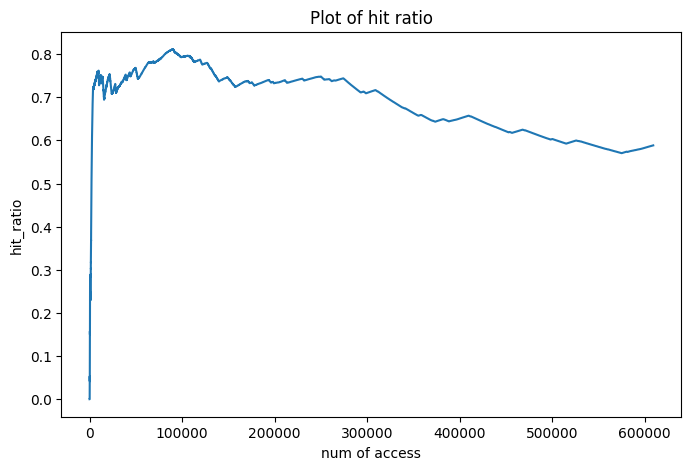

In [3]:
plt.figure(figsize=(8,5))
plt.plot(df['hit_ratio'])
plt.xlabel('num of access')
plt.ylabel('hit_ratio')
plt.title('Plot of hit ratio')
plt.show()

In [4]:
#cache warmming 일때의 상황 제외
df = df.loc[df['warm']!=1]
df.drop(['warm'], axis=1, inplace=True)
df.head()

,readOrwrite,address,avg_freq,avg_reuse,avg_recency,std_freq,std_reuse,std_recency,hit_ratio
1797,0,439373824,1.75,156.02,844.30,1.180686,269.197053,484.189774,0.430478
1798,0,397709312,1.76,156.08,845.12,1.182128,269.196637,484.466181,0.430795
1799,0,396718080,1.76,156.03,846.09,1.185217,269.212928,484.527827,0.431111
1800,0,396546048,1.76,156.00,847.04,1.188296,269.222782,484.602516,0.431427
1801,0,396611584,1.76,155.99,847.99,1.192187,269.226917,484.693339,0.431743


In [5]:
#feature 증폭
df['pre_avg_freq'] = df['avg_freq'].shift(periods=1)
df['pre_avg_reuse'] = df['avg_reuse'].shift(periods=1)
df['pre_std_freq'] = df['std_freq'].shift(periods=1)
df['pre_std_reuse'] = df['std_reuse'].shift(periods=1)


df['5avgOfavg_freq']=df['avg_freq'].rolling(window=10).mean() #avg_freq의 이전5개까지의 평균
df['5avgOfavg_reuse']=df['avg_reuse'].rolling(window=10).mean() #avg_reuse의 이전5개까지의 평균

df['5stdOfavg_freq']=df['avg_freq'].rolling(window=10).std() #avg_freq의 이전5개까지의 표준편차
df['5stdOfavg_reuse']=df['avg_reuse'].rolling(window=10).std() #avg_reuse의 이전5개까지의 표준편차


In [6]:
df

,readOrwrite,address,avg_freq,avg_reuse,avg_recency,std_freq,std_reuse,std_recency,hit_ratio,pre_avg_freq,pre_avg_reuse,pre_std_freq,pre_std_reuse,5avgOfavg_freq,5avgOfavg_reuse,5stdOfavg_freq,5stdOfavg_reuse
1797,0,439373824,1.75,156.02,844.30,1.180686,269.197053,484.189774,0.430478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1798,0,397709312,1.76,156.08,845.12,1.182128,269.196637,484.466181,0.430795,1.75,156.02,1.180686,269.197053,NaN,NaN,NaN,NaN
1799,0,396718080,1.76,156.03,846.09,1.185217,269.212928,484.527827,0.431111,1.76,156.08,1.182128,269.196637,NaN,NaN,NaN,NaN
1800,0,396546048,1.76,156.00,847.04,1.188296,269.222782,484.602516,0.431427,1.76,156.03,1.185217,269.212928,NaN,NaN,NaN,NaN
1801,0,396611584,1.76,155.99,847.99,1.192187,269.226917,484.693339,0.431743,1.76,156.00,1.188296,269.222782,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609306,0,782336,350.90,27585.10,196639.17,629.431482,64058.647884,198080.097373,0.588355,350.90,27585.34,629.429728,64058.543875,350.896,27586.107,0.005164,0.680203
609307,0,476356608,350.90,27584.70,196640.02,629.433127,64058.816352,198080.255329,0.588356,350.90,27585.10,629.431482,64058.647884,350.897,27585.870,0.004831,0.719157
609308,0,395972608,350.90,27584.57,196640.85,629.434164,64058.871386,198080.420066,0.588357,350.90,27584.70,629.433127,64058.816352,350.898,27585.631,0.004217,0.713782
609309,0,476364800,350.90,27584.37,196641.69,629.435497,64058.960078,198080.578992,0.588357,350.90,27584.57,629.434164,64058.871386,350.899,27585.394,0.003163,0.697927


In [7]:
#정규화
scaler = MinMaxScaler()
df[:] = scaler.fit_transform(df[:])


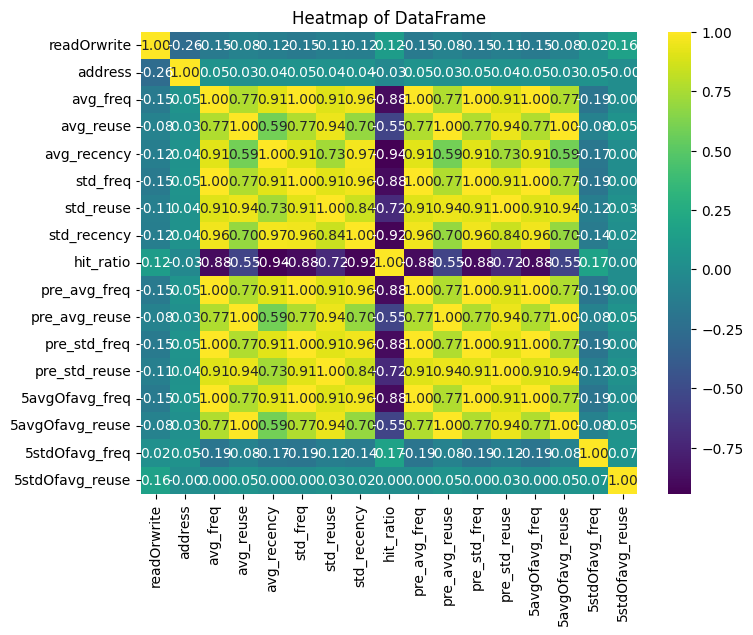

In [ ]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title('Heatmap of DataFrame')
plt.show()  
# Add this line to explicitly display the plot

In [ ]:
#필요없는 데이터 삭제
df.drop(['address'], axis=1, inplace=True)
df.drop(['readOrwrite'], axis=1, inplace=True)
df.drop(['5stdOfavg_freq'], axis=1, inplace=True)
df.drop(['5stdOfavg_reuse'], axis=1, inplace=True)
#결측치 제거
df =df.dropna()

([<matplotlib.axis.XTick at 0x7f542a5cf6a0>,
 [Text(1, 0, 'avg_freq'),
  Text(2, 0, 'avg_reuse'),
  Text(3, 0, 'avg_recency'),
  Text(4, 0, 'std_freq'),
  Text(5, 0, 'std_reuse'),
  Text(6, 0, 'std_recency'),
  Text(7, 0, 'hit_ratio'),
  Text(8, 0, 'pre_avg_freq'),
  Text(9, 0, 'pre_avg_reuse'),
  Text(10, 0, 'pre_std_freq'),
  Text(11, 0, 'pre_std_reuse'),
  Text(12, 0, '5avgOfavg_freq'),
  Text(13, 0, '5avgOfavg_reuse')])

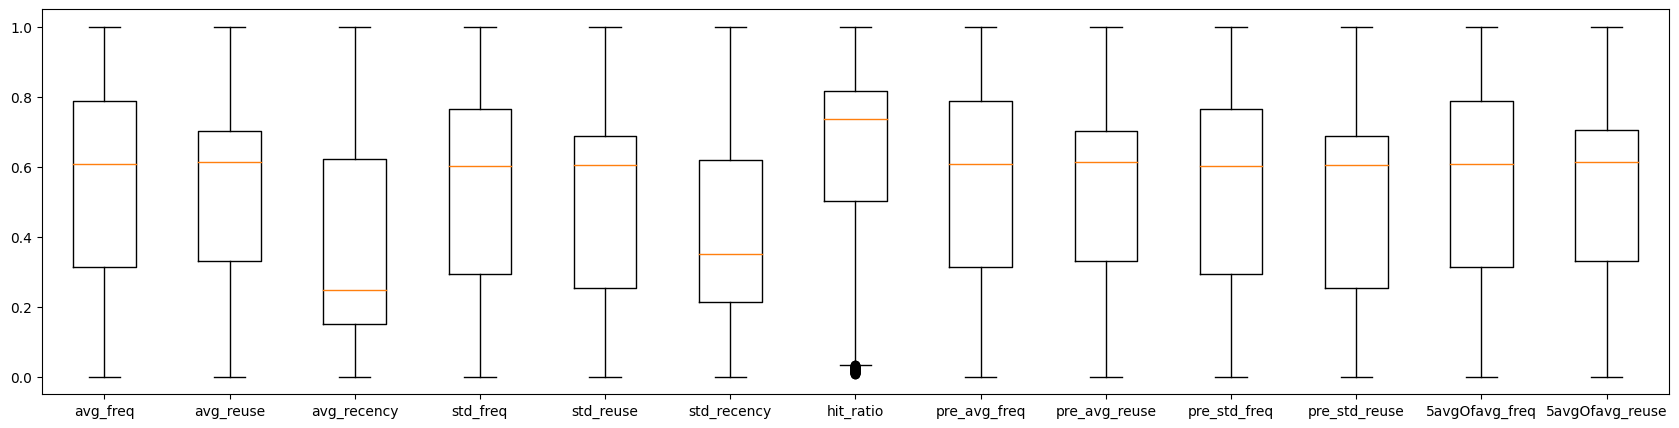

In [ ]:
#box plot으로 이상치 확인
plt.figure(figsize=(21,5))
plt.boxplot(df)

x_labels= list(df.columns)
plt.xticks(range(1,14), x_labels)

In [ ]:
#hit ratio의 예측 범위가 너무 작은 것 같아서 *100
df['hit_ratio'] = df['hit_ratio']*100

/tmp/ipykernel_1751129/517345594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hit_ratio'] = df['hit_ratio']*100


In [ ]:
y = df['hit_ratio']
x = df.drop(['hit_ratio'], axis=1)

X_train, X_test = train_test_split(x, test_size=0.2, shuffle=False,)
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)


In [ ]:
param  = {
    "n_estimators" : 50000, 
    "learning_rate":0.01,
    "metric" : 'mse',
    "objective" : 'regression',
    'max_depth' : -1,
    'num_leaves' : 62
}

In [ ]:
lgbr = LGBMRegressor(**param)
bst = lgbr.fit(X_train,y_train)

y_pred = lgbr.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 486004, number of used features: 12
[LightGBM] [Info] Start training from score 73.885386


KeyboardInterrupt: 

In [ ]:
y_pred

array([35.29008082, 35.29023338, 35.29022248, ..., 35.0964192 ,
       35.0964192 , 35.0964192 ])

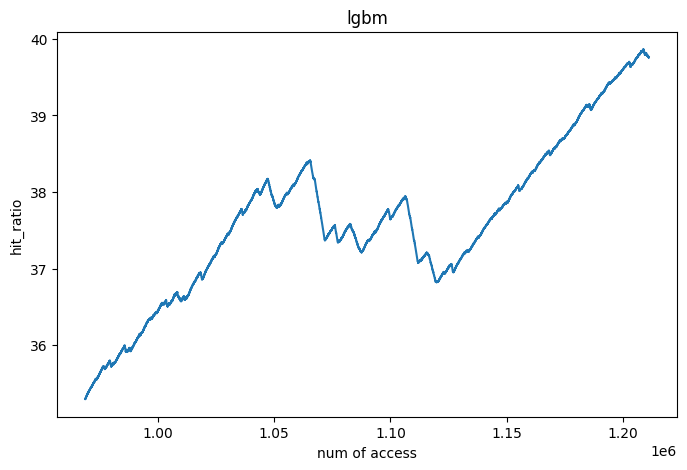

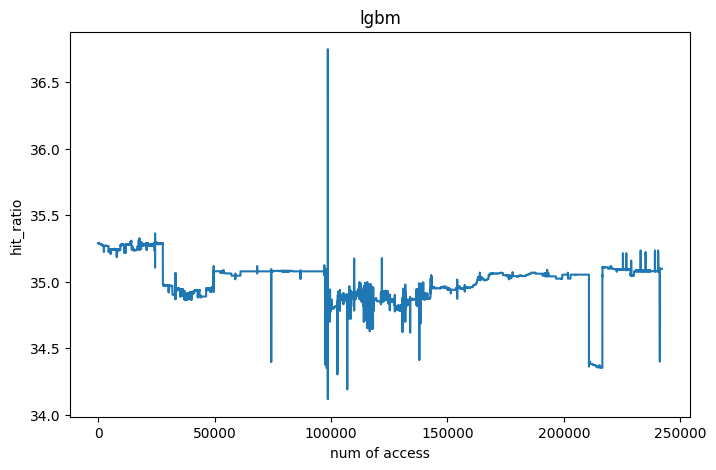

In [ ]:
#y_test = y_test.reset_index(drop=True)
#y_test = y_test.reset_index()


plt.figure(figsize=(8,5))
plt.plot(y_test)
plt.xlabel('num of access')
plt.ylabel('hit_ratio')
plt.title('lgbm')
plt.show()

plt.figure(figsize=(8,5))
plt.plot(y_pred)
plt.xlabel('num of access')
plt.ylabel('hit_ratio')
plt.title('lgbm')
plt.show()



<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

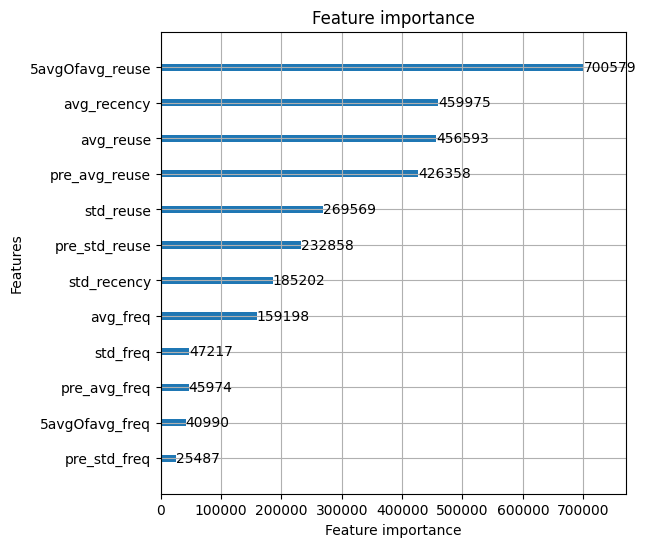

In [ ]:
f, ax = plt.subplots(figsize=(6,6))
plot_importance(bst,ax=ax)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_run = RandomForestRegressor(random_state=0, min_samples_leaf=8, min_samples_split=8, n_estimators=30000)
rf_run.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
valid_predict = rf_run.predict(X_test)

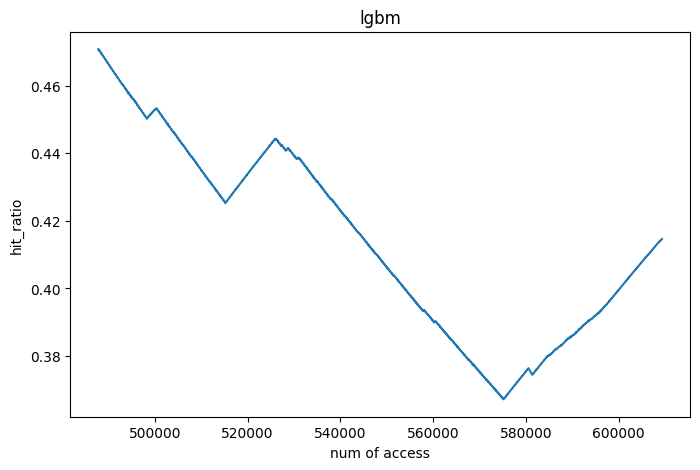

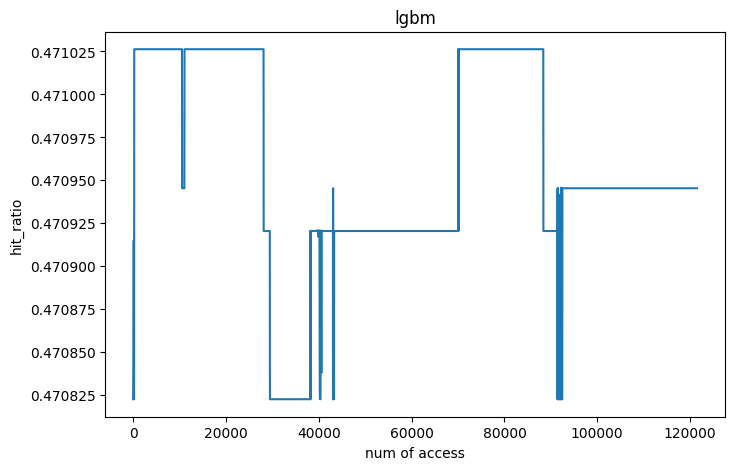

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(y_test)
plt.xlabel('num of access')
plt.ylabel('hit_ratio')
plt.title('rf')
plt.show()

plt.figure(figsize=(8,5))
plt.plot(valid_predict)
plt.xlabel('num of access')
plt.ylabel('hit_ratio')
plt.title('rf')
plt.show()

In [ ]:
X_train

,avg_freq,avg_reuse,avg_recency,std_freq,std_reuse,std_recency,pre_avg_freq,pre_avg_reuse,pre_std_freq,pre_std_reuse,5avgOfavg_freq,5avgOfavg_reuse
1806,0.000029,0.000099,0.000037,0.000040,0.000159,0.000007,0.000029,0.000100,0.000035,0.000158,0.000000,0.000091
1807,0.000029,0.000097,0.000041,0.000045,0.000159,0.000007,0.000029,0.000099,0.000040,0.000159,0.000003,0.000090
1808,0.000057,0.000093,0.000045,0.000052,0.000159,0.000007,0.000029,0.000097,0.000045,0.000159,0.000006,0.000089
1809,0.000057,0.000092,0.000050,0.000057,0.000159,0.000007,0.000057,0.000093,0.000052,0.000159,0.000009,0.000088
1810,0.000057,0.000092,0.000054,0.000064,0.000160,0.000008,0.000057,0.000092,0.000057,0.000159,0.000011,0.000087
...,...,...,...,...,...,...,...,...,...,...,...,...
487805,0.829328,0.683000,0.731010,0.813853,0.691242,0.648152,0.829328,0.683000,0.813855,0.691242,0.829324,0.683884
487806,0.829328,0.683000,0.731014,0.813853,0.691242,0.648152,0.829328,0.683000,0.813855,0.691242,0.829324,0.683884
487807,0.829328,0.683000,0.731019,0.813853,0.691242,0.648152,0.829328,0.683000,0.813855,0.691242,0.829324,0.683884
487808,0.829328,0.683000,0.731023,0.813853,0.691242,0.648152,0.829328,0.683000,0.813855,0.691242,0.829324,0.683884


In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('../msr_traindata.txt', sep=',')
df

,readOrwrite,address,avg_freq,avg_reuse,avg_recency,std_freq,std_reuse,std_recency,warm,hit_ratio
0,0,383496192,0.0,0.00,1.00,0.000000,0.000000,0.000000,1,0.000000
1,0,2822144,0.0,0.00,2.00,0.031235,0.000000,0.031235,1,0.000000
2,0,-1073700864,0.0,0.00,3.00,0.044151,0.000000,0.069816,1,0.000000
3,0,3354624,0.0,0.00,3.99,0.054047,0.000000,0.116780,1,0.000000
4,0,2961408,0.0,0.00,4.99,0.062378,0.000000,0.170884,1,0.000000
...,...,...,...,...,...,...,...,...,...,...
609306,0,782336,350.9,27585.10,196639.17,629.431482,64058.647884,198080.097373,0,0.588355
609307,0,476356608,350.9,27584.70,196640.02,629.433127,64058.816352,198080.255329,0,0.588356
609308,0,395972608,350.9,27584.57,196640.85,629.434164,64058.871386,198080.420066,0,0.588357
609309,0,476364800,350.9,27584.37,196641.69,629.435497,64058.960078,198080.578992,0,0.588357


In [3]:
#cache warmming 일때의 상황 제외
df = df.loc[df['warm']!=1]
df.drop(['warm'], axis=1, inplace=True)
df.head()

/tmp/ipykernel_86065/2584869726.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['warm'], axis=1, inplace=True)


,readOrwrite,address,avg_freq,avg_reuse,avg_recency,std_freq,std_reuse,std_recency,hit_ratio
1797,0,439373824,1.75,156.02,844.30,1.180686,269.197053,484.189774,0.430478
1798,0,397709312,1.76,156.08,845.12,1.182128,269.196637,484.466181,0.430795
1799,0,396718080,1.76,156.03,846.09,1.185217,269.212928,484.527827,0.431111
1800,0,396546048,1.76,156.00,847.04,1.188296,269.222782,484.602516,0.431427
1801,0,396611584,1.76,155.99,847.99,1.192187,269.226917,484.693339,0.431743


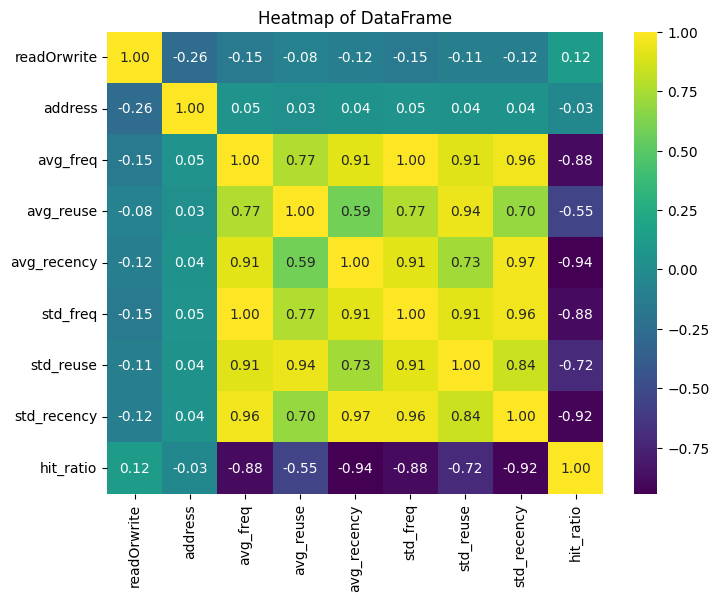

In [4]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title('Heatmap of DataFrame')
plt.show()  
# Add this line to explicitly display the plot

In [5]:
#필요없는 데이터 삭제
df.drop(['address'], axis=1, inplace=True)
df.drop(['readOrwrite'], axis=1, inplace=True)

#결측치 제거
df =df.dropna()

/tmp/ipykernel_86065/1964969279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['address'], axis=1, inplace=True)
/tmp/ipykernel_86065/1964969279.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['readOrwrite'], axis=1, inplace=True)


In [6]:
#이상치 제거

def detect_outliers(df,columns):
    q1=df[columns].quantile(0.25)
    q3=df[columns].quantile(0.75)
    iqr = q3-q1

    boundary = 1.5*iqr
    print(boundary)
    index = df[df[columns] > q3+boundary].index

    df.drop(index, inplace = True)


detect_outliers(df,'avg_reuse')
detect_outliers(df,'std_reuse')


17781.78
42063.194235375


In [7]:

detect_outliers(df,'avg_reuse')

17781.78


In [8]:
df = df.reset_index(drop=True) 
df = df.reset_index()

dates = df['index']

df.drop(['index'],axis = 1, inplace = True)

In [9]:
# 정규화
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns =df.columns)

In [10]:
detect_outliers(df,'std_reuse')

0.6509529106048426


([<matplotlib.axis.XTick at 0x7f07d738b130>,
 [Text(1, 0, 'avg_freq'),
  Text(2, 0, 'avg_reuse'),
  Text(3, 0, 'avg_recency'),
  Text(4, 0, 'std_freq'),
  Text(5, 0, 'std_reuse'),
  Text(6, 0, 'std_recency'),
  Text(7, 0, 'hit_ratio')])

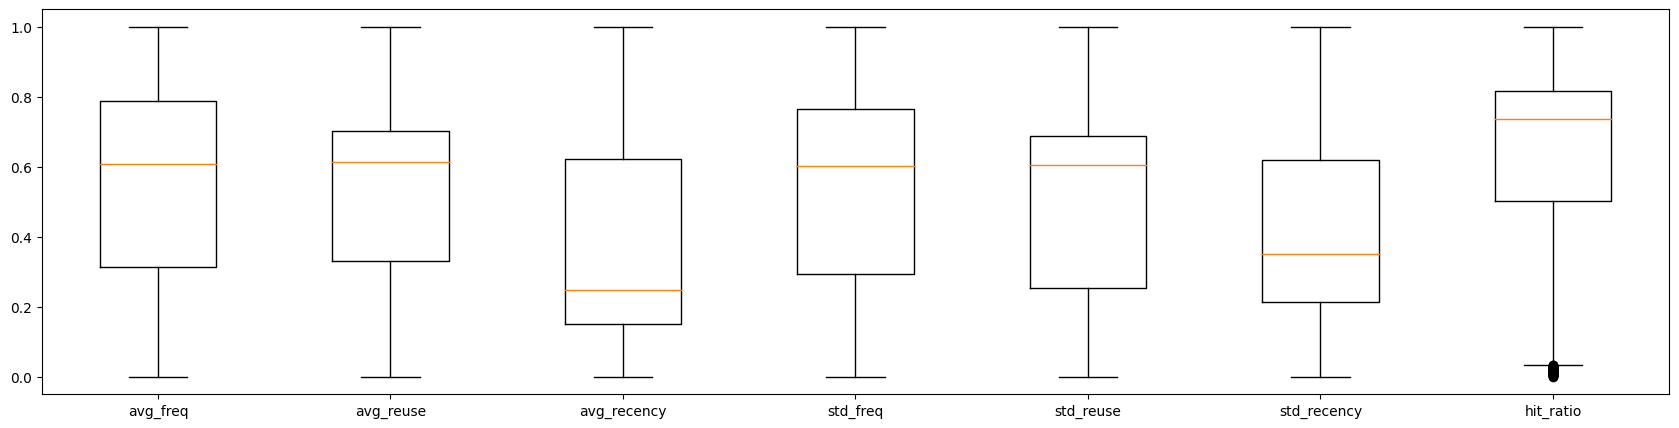

In [11]:
#box plot 정규화 확인
plt.figure(figsize=(21,5))
plt.boxplot(df)

x_labels= list(df.columns)
plt.xticks(range(1,8), x_labels)

([<matplotlib.axis.XTick at 0x7f07d728a2b0>,
 [Text(1, 0, 'avg_freq'),
  Text(2, 0, 'avg_reuse'),
  Text(3, 0, 'avg_recency'),
  Text(4, 0, 'std_freq'),
  Text(5, 0, 'std_reuse'),
  Text(6, 0, 'std_recency'),
  Text(7, 0, 'hit_ratio')])

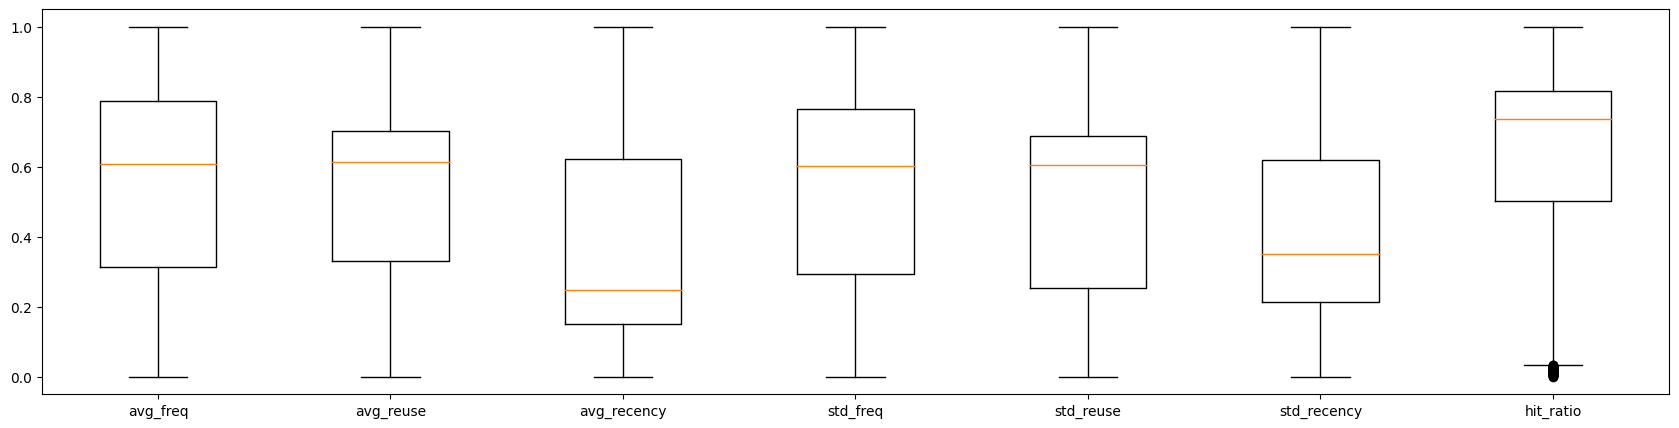

In [12]:
#box plot 정규화 확인
plt.figure(figsize=(21,5))
plt.boxplot(df)

x_labels= list(df.columns)
plt.xticks(range(1,8), x_labels)

In [13]:
df

,avg_freq,avg_reuse,avg_recency,std_freq,std_reuse,std_recency,hit_ratio
0,0.000000,0.000103,0.000000,0.000000,0.000158,0.000000,0.000000
1,0.000029,0.000105,0.000004,0.000002,0.000158,0.000001,0.000833
2,0.000029,0.000104,0.000008,0.000007,0.000158,0.000002,0.001662
3,0.000029,0.000103,0.000012,0.000012,0.000158,0.000002,0.002492
4,0.000029,0.000102,0.000017,0.000018,0.000158,0.000003,0.003322
...,...,...,...,...,...,...,...
607509,1.000000,0.863928,0.878875,0.999991,0.987337,0.999997,0.414632
607510,1.000000,0.863915,0.878879,0.999994,0.987340,0.999998,0.414635
607511,1.000000,0.863911,0.878883,0.999996,0.987341,0.999998,0.414637
607512,1.000000,0.863905,0.878887,0.999998,0.987342,0.999999,0.414637


In [14]:
# split to train data and test data
n_train = int(0.3*df.shape[0])

WINDOW_SIZE = 10

train = df[:-n_train]
test = df[-n_train:]

def make_dataset(data, label, window_size=WINDOW_SIZE):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)


feature_cols = ['avg_freq','avg_reuse','avg_recency','std_freq','std_reuse','std_recency']
label_cols = ['hit_ratio']

train_feature = train[feature_cols]
train_label = train[label_cols]


test_feature = test[feature_cols]
test_label = test[label_cols]

x_train, y_train = make_dataset(train_feature, train_label, WINDOW_SIZE)
x_test, y_test = make_dataset(test_feature, test_label, WINDOW_SIZE)

In [15]:
y_train.size

425250

In [16]:
y_test.size

182244

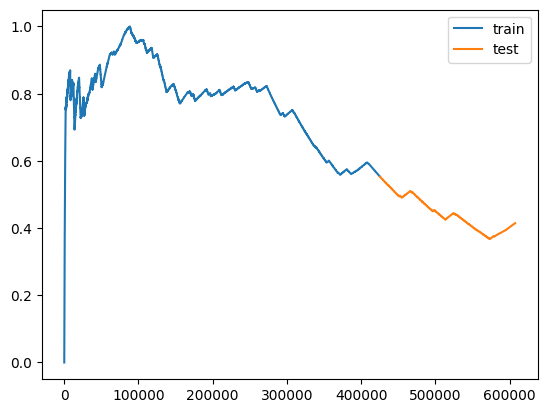

In [17]:
ax = train['hit_ratio'].plot()
test['hit_ratio'].plot(ax=ax)
plt.legend(['train', 'test'])

In [18]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import os
import tensorflow as tf


2024-01-02 16:28:44.854638: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-02 16:28:45.187397: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-02 16:28:46.070884: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [19]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [20]:
model = Sequential()
model.add(LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2]), 
               return_sequences=False))
model.add(Dense(32))
model.add(Dense(y_train.shape[1]))

2024-01-02 16:28:47.834888: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22275 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18176     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20289 (79.25 KB)
Trainable params: 20289 (79.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# specify your learning rate
learning_rate = 0.001
# create an Adam optimizer with the specified learning rate
# optimizer = Adam(learning_rate=learning_rate)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# compile your model using the custom optimizer
model.compile(optimizer='adam', loss='mse')

history = model.fit(x_train, y_train, epochs=100, batch_size=20,validation_split=0.1, verbose=1, callbacks=[es])


Epoch 1/100


2024-01-02 16:28:50.444470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-02 16:28:50.664133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-02 16:28:50.835443: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0620046410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-02 16:28:50.835468: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-01-02 16:28:50.849347: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-02 16:28:51.044718: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

19137/19137 [==============================] - 140s 7ms/step - loss: 0.0015 - val_loss: 8.2567e-04
Epoch 2/100
19137/19137 [==============================] - 137s 7ms/step - loss: 1.7862e-04 - val_loss: 7.7522e-04
Epoch 3/100
19137/19137 [==============================] - 138s 7ms/step - loss: 1.0935e-04 - val_loss: 0.0011
Epoch 4/100
19137/19137 [==============================] - 137s 7ms/step - loss: 8.9210e-05 - val_loss: 9.3693e-04
Epoch 5/100
19137/19137 [==============================] - 137s 7ms/step - loss: 7.8953e-05 - val_loss: 0.0011
Epoch 6/100
19137/19137 [==============================] - 138s 7ms/step - loss: 6.8478e-05 - val_loss: 7.7672e-04
Epoch 7/100
19137/19137 [==============================] - 138s 7ms/step - loss: 5.5705e-05 - val_loss: 0.0010
Epoch 8/100
19137/19137 [==============================] - 138s 7ms/step - loss: 4.5798e-05 - val_loss: 0.0011
Epoch 9/100
19137/19137 [==============================] - 138s 7ms/step - loss: 4.5571e-05 - val_loss: 7.4548e-

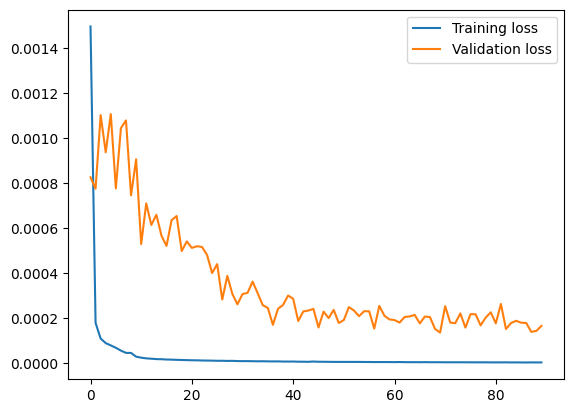

In [23]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label=
         'Validation loss')
plt.legend()
plt.show()

In [24]:
# prediction
prediction = model.predict(x_test)
print(prediction.shape, y_test.shape)

5696/5696 [==============================] - 20s 3ms/step
(182244, 1) (182244, 1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


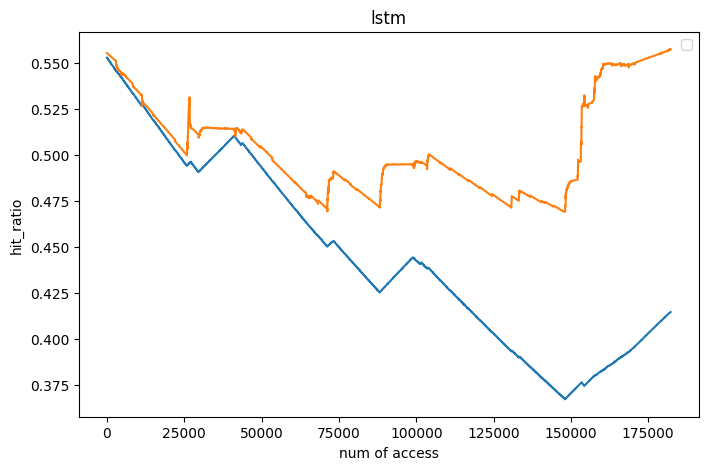

In [25]:
plt.figure(figsize=(8,5))
plt.plot(y_test)
plt.plot(prediction)
plt.xlabel('num of access')
plt.ylabel('hit_ratio')
plt.legend()
plt.title('lstm')
plt.show()

In [27]:
file_object  = open("msr_result.txt", "w+")
file_object.write("dkdkkd")
# for i in prediction:
#      file_object.write("%s\n" % (i))
# file_object.close()

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2]), 
               return_sequences=False))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(y_train.shape[1]))

# specify your learning rate
learning_rate = 0.001
# create an Adam optimizer with the specified learning rate
# optimizer = Adam(learning_rate=learning_rate)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# compile your model using the custom optimizer
model.compile(optimizer='adam', loss='mse')


history = model.fit(x_train, y_train, epochs=100, batch_size=16,validation_split=0.1, verbose=1, callbacks=[es])

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# prediction
prediction = model.predict(x_test)

Epoch 1/100
  107/23921 [..............................] - ETA: 1:57 - loss: 0.0560

KeyboardInterrupt: 

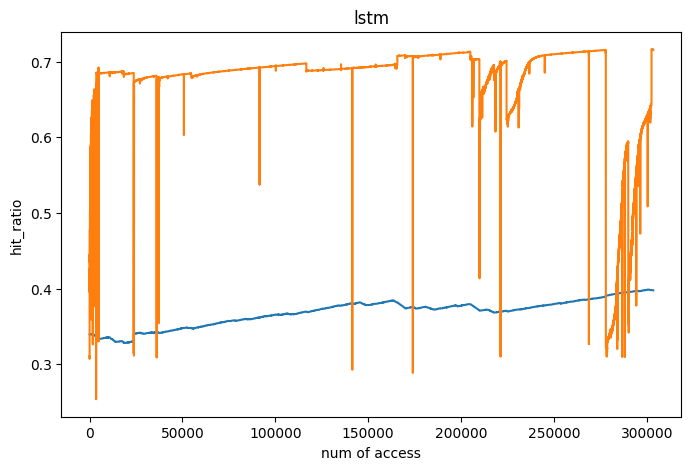

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(y_test)
plt.plot(prediction)
plt.xlabel('num of access')
plt.ylabel('hit_ratio')
plt.title('lstm')
plt.show()

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2]), 
               return_sequences=False))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(y_train.shape[1]))

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 10, 64)            448       
                                                                 
 dense_29 (Dense)            (None, 10, 32)            2080      
                                                                 
 dense_30 (Dense)            (None, 10, 16)            528       
                                                                 
 dense_31 (Dense)            (None, 10, 1)             17        
                                                                 
Total params: 3073 (12.00 KB)
Trainable params: 3073 (12.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# specify your learning rate
learning_rate = 0.001
# create an Adam optimizer with the specified learning rate
# optimizer = Adam(learning_rate=learning_rate)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# compile your model using the custom optimizer
model.compile(optimizer='adam', loss='mse')


history = model.fit(x_train, y_train, epochs=200, batch_size=20,validation_split=0.1, verbose=1, callbacks=[es])

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# prediction
prediction = model.predict(x_test)

Epoch 1/200
  404/19137 [..............................] - ETA: 1:10 - loss: 0.0159

KeyboardInterrupt: 

In [ ]:
# specify your learning rate
learning_rate = 0.001
# create an Adam optimizer with the specified learning rate
# optimizer = Adam(learning_rate=learning_rate)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# compile your model using the custom optimizer
model.compile(optimizer='adam', loss='mse')


history = model.fit(x_train, y_train, epochs=200, batch_size=20,validation_split=0.1, verbose=1, callbacks=[es])

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# prediction
prediction = model.predict(x_test)

ValueError: x and y can be no greater than 2D, but have shapes (182244,) and (182244, 10, 1)

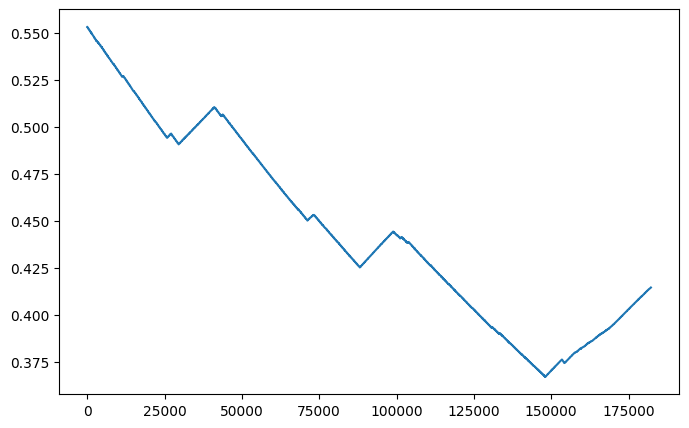

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(y_test)
plt.plot(prediction)
plt.xlabel('num of access')
plt.ylabel('hit_ratio')
plt.title('lstm')
plt.show()

In [ ]:
import joblib
joblib.dump(model, './ml_model/predict_model.pkl')

FileNotFoundError: [Errno 2] No such file or directory: './ml_model/predict_model.pkl'

Epoch 1/100
33907/33907 [==============================] - 215s 6ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 2/100
33907/33907 [==============================] - 214s 6ms/step - loss: 3.6599e-04 - val_loss: 0.0165
Epoch 3/100
33907/33907 [==============================] - 213s 6ms/step - loss: 1.5529e-04 - val_loss: 0.0312
Epoch 4/100
33907/33907 [==============================] - 214s 6ms/step - loss: 1.0347e-04 - val_loss: 0.0200
Epoch 5/100
33907/33907 [==============================] - 203s 6ms/step - loss: 7.9395e-05 - val_loss: 0.0264
Epoch 6/100
33907/33907 [==============================] - 214s 6ms/step - loss: 6.9913e-05 - val_loss: 0.0341
Epoch 6: early stopping


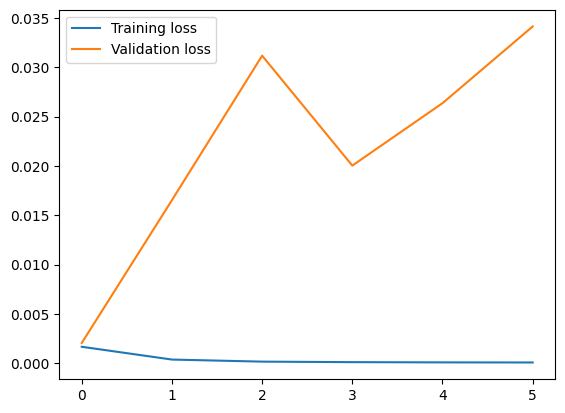

11353/11353 [==============================] - 33s 3ms/step


In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2]), 
               return_sequences=False))
model.add(Dense(32))
model.add(Dense(y_train.shape[1]))

# specify your learning rate
learning_rate = 0.001
# create an Adam optimizer with the specified learning rate
# optimizer = Adam(learning_rate=learning_rate)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# compile your model using the custom optimizer
model.compile(optimizer='adam', loss='mse')


history = model.fit(x_train, y_train, epochs=100, batch_size=20,validation_split=0.2,
                     verbose=1, callbacks=[es])

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# prediction
prediction = model.predict(x_test)

ValueError: x and y can be no greater than 2D, but have shapes (182244,) and (182244, 10, 1)

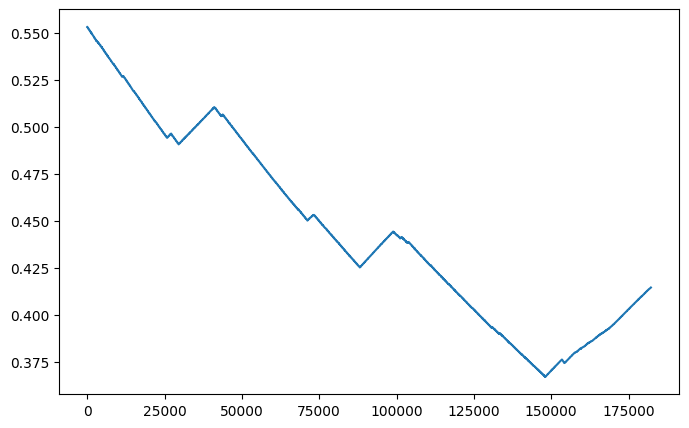

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(y_test)
plt.plot(prediction)
plt.xlabel('num of access')
plt.ylabel('hit_ratio')
plt.title('lstm')
plt.show()

Epoch 1/100
33907/33907 [==============================] - 231s 7ms/step - loss: 0.0015 - val_loss: 9.6776e-04
Epoch 2/100
33907/33907 [==============================] - 229s 7ms/step - loss: 2.1966e-04 - val_loss: 0.0020
Epoch 3/100
33907/33907 [==============================] - 229s 7ms/step - loss: 1.4009e-04 - val_loss: 0.0010
Epoch 4/100
33907/33907 [==============================] - 213s 6ms/step - loss: 1.0265e-04 - val_loss: 0.0103
Epoch 5/100
33907/33907 [==============================] - 228s 7ms/step - loss: 8.1728e-05 - val_loss: 0.0201
Epoch 6/100
33907/33907 [==============================] - 227s 7ms/step - loss: 7.0423e-05 - val_loss: 0.0496
Epoch 6: early stopping


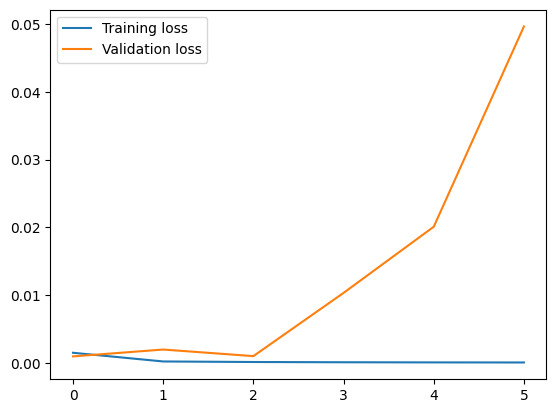

11353/11353 [==============================] - 33s 3ms/step


In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2]), 
               return_sequences=False))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(y_train.shape[1]))

# specify your learning rate
learning_rate = 0.001
# create an Adam optimizer with the specified learning rate
# optimizer = Adam(learning_rate=learning_rate)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# compile your model using the custom optimizer
model.compile(optimizer='adam', loss='mse')


history = model.fit(x_train, y_train, epochs=100, batch_size=20,validation_split=0.2, verbose=1, callbacks=[es])

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# prediction
prediction = model.predict(x_test)

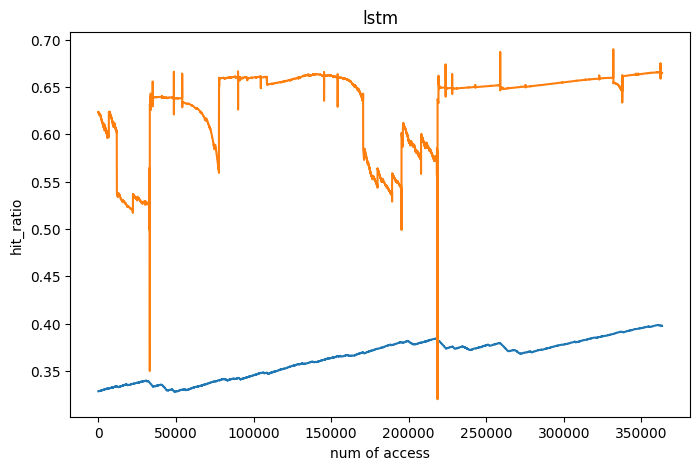

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(y_test)
plt.plot(prediction)
plt.xlabel('num of access')
plt.ylabel('hit_ratio')
plt.title('lstm')
plt.show()

In [ ]:
prediction[1][0]

0.6235048

In [ ]:
pred = []

for i in range(y_test.size):
    pred.append(prediction[i][0])


In [ ]:
pred

[0.6235205,
 0.6235048,
 0.62348545,
 0.6234655,
 0.6234453,
 0.62342983,
 0.62342346,
 0.62342626,
 0.623438,
 0.6234605,
 0.6234932,
 0.62350845,
 0.623533,
 0.62354326,
 0.6235345,
 0.62352175,
 0.6235101,
 0.6235012,
 0.62349737,
 0.6234921,
 0.6234822,
 0.6234706,
 0.6234594,
 0.6234488,
 0.62343544,
 0.62342024,
 0.6234015,
 0.6233834,
 0.62336624,
 0.62335485,
 0.6233505,
 0.62335175,
 0.6233599,
 0.62337613,
 0.6234011,
 0.6234195,
 0.6234282,
 0.6234211,
 0.62341475,
 0.62341034,
 0.62340844,
 0.62340575,
 0.62340796,
 0.62340164,
 0.62339735,
 0.6233968,
 0.6233861,
 0.623377,
 0.62336755,
 0.62335974,
 0.6233524,
 0.623347,
 0.6233361,
 0.62332594,
 0.6233151,
 0.62330455,
 0.623294,
 0.62328374,
 0.62327266,
 0.6232598,
 0.62324625,
 0.62323177,
 0.6232184,
 0.6232064,
 0.6231964,
 0.62318933,
 0.6231863,
 0.62318516,
 0.6231858,
 0.6231905,
 0.62318045,
 0.6231701,
 0.62316006,
 0.6231508,
 0.62314034,
 0.6231291,
 0.6231173,
 0.623106,
 0.62309396,
 0.6230811,
 0.623069,


NameError: name 'pred' is not defined

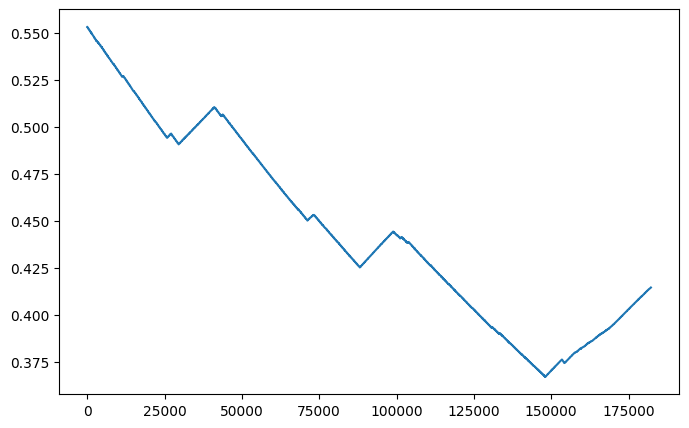

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(y_test)
plt.plot(pred)
plt.xlabel('num of access')
plt.ylabel('hit_ratio')
plt.title('lstm')
plt.show()


In [ ]:

182244